# Assignment Sheet 3
## Solution examples

## Task 3.1) 
Consider the following grid world:

![title](gridWorld.png)

The agent may start in any cell.

It can choose between four actions: moving one cell up, moving one cell down, moving one cell
left, and moving one cell right.

When it reaches cell $G$, it will receive $100$ points and the episode ends.

When it reaches a cell marked $*$, it will receive $10$ points and the episode continues.

When it attempts to enter a cell marked $X$, it will receive $-20$ points and stay in the cell it came
from.

When it attempts to leave the grid, it will receive $-30$ points and stay where it is.

All actions entering an unmarked cell will receive $-1$ point.

Compute the expected value of all cells for a policy that chooses with probability $0.5$ a random
action and otherwise moves to the right.

The discount parameter shall be $\gamma=0.9$.

First, we need to define the framework for this gridworld. I decide on representing the grid world using a $(9$ x $9)$ numpy array. Individual cells can be accessed using tuples of the form $(y,x)$ and store $-1$ for empty cells, $-20$ for walls, $10$ for stars and $100$ for the terminal states.

In [1]:
import numpy as np

gridworld = -1. * np.ones((9,9))
stars = [(0,0), (0,1), (0,2), (0,7), (0,8), (1,8), \
         (3,2), (3,3), (3,4), (3,5), (4,2), \
         (7,1), (7,2), (7,3), (7,4), (7,5), (7,6), \
         (8,1), (8,2), (8,3), (8,5), (8,6)]
for cell in stars:
    gridworld[cell] = 10.

obstacles = [(1,5), (1,7), (2,1), (2,2), (2,3), (2,4), (2,5), (2,7), \
             (3,1), (3,6), (4,3), (4,4), (4,5), (5,7), \
             (6,1), (6,2), (6,3), (6,4), (6,5), (6,6),\
             (7,8), (8,4), (8,8)]
for cell in obstacles:
    gridworld[cell] = -20.

terminalStates = [(3,8)]
for cell in terminalStates:
    gridworld[cell] = 100.

print(gridworld)
np.save('gridworld.npy', gridworld)

[[ 10.  10.  10.  -1.  -1.  -1.  -1.  10.  10.]
 [ -1.  -1.  -1.  -1.  -1. -20.  -1. -20.  10.]
 [ -1. -20. -20. -20. -20. -20.  -1. -20.  -1.]
 [ -1. -20.  10.  10.  10.  10. -20.  -1. 100.]
 [ -1.  -1.  10. -20. -20. -20.  -1.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1. -20.  -1.]
 [ -1. -20. -20. -20. -20. -20. -20.  -1.  -1.]
 [ -1.  10.  10.  10.  10.  10.  10.  -1. -20.]
 [ -1.  10.  10.  10. -20.  10.  10.  -1. -20.]]


Next, we need to represent the reward of taking actions for each action in each state. We create another numpy array of the shape ($8$ x $9$ x $9)$. The first axis has $8$ entries because we will need $8$ actions in later tasks. The actions are indexed in a clockwise fashion: Northwest-North-Northeast-East-Southeast-South-Southwest-West.

For each action, we want to know what reward executing it in a certain cell entails. For example, executing the action $\textit{North}$ in the cell $(4,8)$ yields a reward of $100$ for entering the terminal state. Executing the same action in $(0,2)$, costs of $30$ incur because it would correspond to leaving the grid. Please note that the origin of our grid world coordinate system is, in this framework, the top-left corner of the grid. Thus, the y-Axis is inverted. For each action, this can be efficiently calculated by constructing an action-kernel and correlating it (think convolution but the kernel is rotated by $180°$) with the grid world. The action-kernel simply encodes the relative position of the cell we attempt to enter when executing the action. For example, for the action $\textit{Southwest}$, we construct

$K_{SW} = \left( \begin{array}{rrr}
0 & 0 & 0 \\
0 & 0 & 0 \\
1 & 0 & 0 \\
\end{array}\right) $.

Before correlation, we pad the grid world with a border of width $1$, filled with the value $-30$, such that actions leaving the grid are also represented correctly.

In [2]:
import cv2

gridworld = np.load('gridworld.npy')

###construct kernels
kernels = []
blankKernel = np.zeros((3,3))
for action in [0, 1, 2, 5, 8, 7, 6, 3]: #[NW, N, NE, E, SE, S, SW, W]
    kernel = blankKernel.copy()
    kernel[np.unravel_index(action, kernel.shape)] = 1.0
    kernels.append(kernel)

###pad borders of the grid with values of -30
paddedGrid = np.pad(gridworld, (1,1), mode = 'constant', constant_values = -30)

###correlate individual action-kernels with the padded grid, build 8x9x9 data structre
rewards = []
for actionKernel in kernels:
    actionRewards = cv2.filter2D(paddedGrid, -1, actionKernel)
    actionRewards = actionRewards[1:(len(actionRewards)-1),:][:,1:(len(actionRewards[0])-1)]
    rewards.append(actionRewards)
rewards = np.array(rewards)

for item in rewards:
    print(item,"\n")
    
np.save('rewards.npy', rewards)

[[-30. -30. -30. -30. -30. -30. -30. -30. -30.]
 [-30.  10.  10.  10.  -1.  -1.  -1.  -1.  10.]
 [-30.  -1.  -1.  -1.  -1.  -1. -20.  -1. -20.]
 [-30.  -1. -20. -20. -20. -20. -20.  -1. -20.]
 [-30.  -1. -20.  10.  10.  10.  10. -20.  -1.]
 [-30.  -1.  -1.  10. -20. -20. -20.  -1.  -1.]
 [-30.  -1.  -1.  -1.  -1.  -1.  -1.  -1. -20.]
 [-30.  -1. -20. -20. -20. -20. -20. -20.  -1.]
 [-30.  -1.  10.  10.  10.  10.  10.  10.  -1.]] 

[[-30. -30. -30. -30. -30. -30. -30. -30. -30.]
 [ 10.  10.  10.  -1.  -1.  -1.  -1.  10.  10.]
 [ -1.  -1.  -1.  -1.  -1. -20.  -1. -20.  10.]
 [ -1. -20. -20. -20. -20. -20.  -1. -20.  -1.]
 [ -1. -20.  10.  10.  10.  10. -20.  -1. 100.]
 [ -1.  -1.  10. -20. -20. -20.  -1.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1. -20.  -1.]
 [ -1. -20. -20. -20. -20. -20. -20.  -1.  -1.]
 [ -1.  10.  10.  10.  10.  10.  10.  -1. -20.]] 

[[-30. -30. -30. -30. -30. -30. -30. -30. -30.]
 [ 10.  10.  -1.  -1.  -1.  -1.  10.  10. -30.]
 [ -1.  -1.  -1.  -1. -20.  -1. -2

The rewards look fine, so we can actually start with the tasks now. On this assignment sheet, the framework constitutes a large share of the total work. Ideally, it is re-usable in each task. For this reason, do not be confused if you recieve points in tasks you did not hand in, as I felt that giving a portion of each tasks' points for the framework was only fair. 

In attempt to be as transparent as possible, we list all algorithms' hyperparameters right at the beginning. Here, $\gamma$ is the discount factor dampening the agent's interest in future rewards, $\theta$ is the convergence criterion for $\textit{iterative policy evaluation}$ and $\textit{value iteration}$, while $\epsilon$ implements the $\textit{policy-stable}$ criterion from lecture $3$ slide $34$.

In [3]:
np.set_printoptions(suppress=True)

#Hyperparameters:
gamma = 0.9
theta = 0.01
eps = 0.01

gridworld = np.load('gridworld.npy')
rewards = np.load('rewards.npy')

In $\textit{iterative policy evaluation}$, the update rule is

$\begin{equation} V(s) \leftarrow \sum_{a}\pi(s,a)\cdot\sum_{s'}P_{ss'}^a\cdot[R_{ss'}^a+\gamma\cdot V(s')]
\end{equation}$.

Of course, the only terms that contribute to the inner sum are those which satisfy $P_{ss'}^a \neq 0$. However, this is only true for very few states, namely those $s'$ which are potentially reached when executing $a$ in $s$. In tasks $1$ through $3$, there is only $1$ potential successor state, in $\textbf{3.4)}$, we have a maximum of $3$ due to random deviations from our intended action. 

From a technical perspective, the challenge is determining the potential successor states as well their respective transtition probabilities. Given the action and state to be examined (note that these are fixed in the inner loop of the update), and the properties of the grid world encoded in our previous framework, we define a function that examines possible state transitions and returns $s'$ such that $P_{ss'}^a \neq 0$ as well as the associated $P_{ss'}^a$ and $R_{ss'}^a$. Calling this function yields everything necessary for calculating the inner sum. We want to use this in task $4$, where we encounter a connatural update rule, so we include the $\textit{deviation}$ case to deal with the uncertainty of the environment. 

In [4]:
def getNextStatesRewardsAndProbabilities(state, action, rewards, deviation = False):
    coordinateActions = [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]
                        #[NW,      N,      NE,     E,     SE,    S,     SW,     W]
    nextStatesAndProbabilities = []
    if deviation:
        actions = [(action + wind)%8 for wind in [-1, 0, 1]] #45° to the left, none, 45° to the right deviations
        probabilities = [0.1, 0.8, 0.1]                    #deviation probabilities defined on the assignment sheet
    else:
        actions = [action]                                   #the agent always executes the selected action correctly
        probabilities = [1.]
    for i,a in enumerate(actions):
        R = rewards[a][state]                                #check which reward the action would yield
        if R < -1.:                                          #if the reward is -1, -5 or -20, s' remains s 
            nextState = state
        else:
            nextState = tuple(map(sum, zip(state, coordinateActions[a]))) #else, actually move to a different s'
        nextStatesAndProbabilities.append([nextState, R, probabilities[i]])
    return nextStatesAndProbabilities

The inner loop of the update rule dealt with, most of the legwork is done. Now we can simply copy the algorithm from lecture $3$, slide $25$. We represent $\pi(s,a)$ using a $(9$ x $9$ x $8)$ numpy array which defines a probability distribution over the actions for each state. 

In [5]:
def iterativePolicyEvaluation(policy, rewards, states, actions, deviation = False):
    delta = theta + 1
    V = np.zeros_like(rewards[0])
    while delta > theta:
        delta = 0.
        for s in states:
            v = V[s]
            sumOverActions = 0.0
            for a in actions:
                sumOverNextStates = 0.0
                for sPrime, R, P in getNextStatesRewardsAndProbabilities(s, a, rewards, deviation):
                    sumOverNextStates += P * (R + gamma * V[sPrime])
                sumOverActions += policy[s][a] * sumOverNextStates
            V[s] = sumOverActions
            delta = max([delta, abs(v - V[s])])
    return V

Since the following code is meant to be independent from the definition of the framework, we need to specify again the locations of obstacles and terminal states. 

In [6]:
states = [(y,x) for y in range(len(gridworld[0])) for x in range(len(gridworld))]
terminalStates = [(3,8)]
obstacles = [(1,5), (1,7), (2,1), (2,2), (2,3), (2,4), (2,5), (2,7), \
             (3,1), (3,6), (4,3), (4,4), (4,5), (5,7), \
             (6,1), (6,2), (6,3), (6,4), (6,5), (6,6),\
             (7,8), (8,4), (8,8)]
statesRelevant = [cell for cell in states if not(cell in terminalStates or cell in obstacles)]

In task 1, the policy is rather arbitrary:

"$[...]$ a policy that chooses with probability $0.5$ a random
action and otherwise moves to the right."

We therefore select $\textit{North}$,  $\textit{East}$,  $\textit{South}$ and  $\textit{West}$ as our available actions and assign to them the probabilities $0.5\cdot0.25$, $0.5\cdot0.25 + 0.5$, $0.5\cdot0.25$ and $0.5\cdot0.25$. Since this distribution exists independently in each state, we tile it over the whole grid world. We execute $\textit{iterative policy evaluation}$ and print $V^{\pi}$.

In [7]:
actions = [1, 3, 5, 7] # = [N, E, S, W]

policy = np.array([0., 0.5 * 0.25, 0., 0.5 * 0.25  + 0.5, 0., 0.5 * 0.25, 0., 0.5 * 0.25])
policy = np.tile(policy, gridworld.shape).reshape(gridworld.shape + (8,))

V = iterativePolicyEvaluation(policy, rewards, statesRelevant, actions)
print("State Values:")
print(np.around(V, 2))
np.save('stateValuesTask1.npy', V)

State Values:
[[ -55.72  -60.29  -76.22  -85.94  -95.17 -102.06 -109.15 -128.04 -154.36]
 [ -70.24  -71.04  -82.43  -97.05 -113.45    0.   -138.84    0.   -140.13]
 [-114.36    0.      0.      0.      0.      0.   -156.42    0.    -71.58]
 [-113.49    0.    -67.69  -82.24 -104.23 -131.61    0.     67.98    0.  ]
 [ -66.87  -61.7   -77.43    0.      0.      0.    -51.57  -41.73  -63.12]
 [ -64.48  -63.87  -69.53  -77.89  -83.19  -88.82  -95.52    0.   -145.96]
 [ -81.41    0.      0.      0.      0.      0.      0.   -146.68 -167.45]
 [ -24.08  -19.83  -28.51  -42.32  -57.4   -75.07 -100.96 -122.15    0.  ]
 [ -29.39  -33.23  -49.04  -73.92    0.    -85.57 -105.1  -125.2     0.  ]]


## Task 3.2)
Use the Policy Iteration algorithm to compute the optimal value $V^*(s)$ for each cell.

Indicate the resulting optimal policy $\pi^*(s)$ with arrows in each cell. 

Since $\textit{policy iteration}$ is simply alternating policy evaluation and policy improvement, and we already have policy evaluation in the form of $\textit{iterative policy evaluation}$, the missing component is policy improvement. Policy improvement is the process of making a policy greedy with respect to $Q(s,a)$:

$\pi_{greedy}(s) := arg\,max_a Q(s,a) = arg\,max_a \sum_{s'}P_{ss'}^a\cdot[R_{ss'}^a+\gamma\cdot V(s')]$.

The aforementioned equality retrieves $Q(s,a)$ from $V(s)$. Since numpy supplies an $argmax()$ method, this is all we need to implement. Notice that this is actually exactly the inner sum from $\textbf{3.1)}$, so we can just upcycle previous code.

In [8]:
def QFromV(V, rewards, states, actions, deviation = False):
    Q = np.tile(np.zeros(8), V.shape).reshape(V.shape + (8,))
    for s in states:
        for a in actions:
            for sPrime, R, P in getNextStatesRewardsAndProbabilities(s, a, rewards, deviation):
                Q[s][a] += P * (R + gamma * V[sPrime])
    return Q

We now have all pieces of the puzzle, and proceed to assemble them closely following lecture $3$, slide $34$. 

In [9]:
def PolicyIteration(rewards, states, actions, initialPolicy = None, deviation = False):
    policyStable = False
    if initialPolicy is not None:
        pi = initialPolicy
    else:
        pi = np.tile(0.125*np.ones(8), rewards[0].shape).reshape(rewards[0].shape + (8,))
    while not(policyStable):
        policyStable = True
        V =iterativePolicyEvaluation(pi, rewards, states, actions, deviation)
        Q = QFromV(V, rewards, states, actions, deviation)
        for s in states:
            b = pi[s].copy()
            pi[s] = np.zeros(8)
            pi[s][np.argmax(Q[s])] = 1.
            if np.linalg.norm(pi[s] - b) > eps:
                policyStable = False
    return V, pi

In this task, we also need to visualize the resulting optimal policy. We could simply print the arrows to the console, but I prefer a prettier plot. However, pyplot was not really designed for this sort of thing, so please excuse (I actually recommend you skip over) the following code which draws deterministic policies.

In [10]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

def drawPolicy(pi, cells = states, terminalStates = terminalStates, obstacles = obstacles, stars = stars):
    ticks = np.arange(0,10)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.axis([0,9,0,9],'equal')
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    fig.gca().set_aspect('equal')
    fig.gca().invert_yaxis()
    ax.grid(True,color='k')
    for axi in (ax.xaxis, ax.yaxis):
        for tic in axi.get_major_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
    for cell in cells:
        if cell in terminalStates:
            rect = Rectangle((cell[1],cell[0]),1,1,color='palegreen')
            ax.add_patch(rect)
        elif cell in obstacles:
            rect = Rectangle((cell[1],cell[0]),1,1,color='lightsalmon')
            ax.add_patch(rect)
        else:
            if cell in stars:
                rect = Rectangle((cell[1],cell[0]),1,1,color='cornflowerblue')
                ax.add_patch(rect)
            if pi[cell][0] == 1.:
                ax.arrow(cell[1]+0.85,cell[0]+0.85,-0.7,-0.7,head_width=0.2, head_length=0.2,length_includes_head=True,
                        fill = True)
            elif pi[cell][1] == 1.:
                ax.arrow(cell[1]+0.5,cell[0]+0.9,0,-0.8,head_width=0.2, head_length=0.2,length_includes_head=True,
                        fill = True)
            elif pi[cell][2] == 1.:
                ax.arrow(cell[1]+0.15,cell[0]+0.85,0.7,-0.7,head_width=0.2, head_length=0.2,length_includes_head=True,
                        fill = True)
            elif pi[cell][3] == 1.:
                ax.arrow(cell[1]+0.1,cell[0]+0.5,0.8,0,head_width=0.2, head_length=0.2,length_includes_head=True,
                        fill = True)
            elif pi[cell][4] == 1.:
                ax.arrow(cell[1]+0.15,cell[0]+0.15,0.7,0.7,head_width=0.2, head_length=0.2,length_includes_head=True,
                        fill = True)
            elif pi[cell][5] == 1.:
                ax.arrow(cell[1]+0.5,cell[0]+0.1,0,0.8,head_width=0.2, head_length=0.2,length_includes_head=True,
                        fill = True)
            elif pi[cell][6] == 1.:
                ax.arrow(cell[1]+0.85,cell[0]+0.15,-0.7,0.7,head_width=0.2, head_length=0.2,length_includes_head=True,
                        fill = True)
            else:
                ax.arrow(cell[1]+0.9,cell[0]+0.5,-0.8,0,head_width=0.2, head_length=0.2,length_includes_head=True,
                        fill = True)

    fig.show()

Optimal values with 4 actions:
[[ 99.98  99.98  99.98  99.98  88.99  88.97  99.98  99.98  99.98]
 [ 99.98  99.98  99.98  88.99  79.09   0.    88.98   0.    99.98]
 [ 88.98   0.     0.     0.     0.     0.    79.08   0.   100.  ]
 [ 79.08   0.    99.98  99.98  99.98  99.98   0.   100.     0.  ]
 [ 88.97  99.98  99.98   0.     0.     0.    79.1   89.   100.  ]
 [ 79.08  88.98  99.98  88.98  79.08  70.18  70.19   0.    89.  ]
 [ 88.96   0.     0.     0.     0.     0.     0.    88.98  79.1 ]
 [ 99.96  99.97  99.97  99.97  99.98  99.98  99.98  99.98   0.  ]
 [ 99.97  99.97  99.97  99.98   0.    99.98  99.98  99.98   0.  ]]


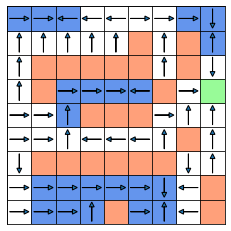

In [11]:
V, pi1 = PolicyIteration(rewards, statesRelevant, actions, initialPolicy = policy)
print("Optimal values with 4 actions:")
print(np.around(V, 2))
drawPolicy(pi1)

## Task 3.3) 
Extend the action set by also allowing diagonal moves, such that the agent can move to its eight neighboring cells.

Use the Value Iteration algorithm to compute the optimal value $V^*(s)$ for each cell.

Indicate the resulting optimal policy $\pi^*(s)$ with arrows in each cell.

Discuss how value and policy changed, compared to 3.2)!

In $\textit{value iteration}$, the update rule is

$\begin{equation} V(s) \leftarrow \max_a \sum_{s'}P_{ss'}^a\cdot[R_{ss'}^a+\gamma\cdot V(s')]
\end{equation}$.

This corresponds to the maximum $Q$ value, which we also know from task $1$ as the maximum addend of the inner sum. Therefore, we have already completed the lion's share of this task. All we need to do is reproduce lecture $3$, slide $38$. 

In [12]:
def valueIteration(rewards, states, actions, deviation = False):
    delta = theta + 1
    V = np.zeros_like(rewards[0])
    while delta > theta:
        delta = 0.
        for s in states:
            v = V[s]
            Q = np.zeros(8)
            for a in actions:
                for sPrime, R, P in getNextStatesRewardsAndProbabilities(s, a, rewards, deviation):
                        Q[a] += P * (R + gamma * V[sPrime])
            V[s] = np.max(Q)
            delta = max([delta, abs(v - V[s])])

    pi = np.tile(np.zeros(8), rewards[0].shape).reshape(rewards[0].shape + (8,))
    Q = QFromV(V, rewards, states, actions, deviation)
    for s in states:
        pi[s][np.argmax(Q[s])] = 1.
    return V, pi

Execute this function, print $V^*$ and draw $\pi^*$. 

Optimal values with 8 actions:
[[ 99.96  99.97  99.97  99.97  88.98  89.   100.   100.   100.  ]
 [ 99.97  99.97  99.97  99.97  88.98   0.   100.     0.   100.  ]
 [ 88.98   0.     0.     0.     0.     0.   100.     0.   100.  ]
 [ 89.     0.   100.   100.   100.   100.     0.   100.     0.  ]
 [ 89.   100.   100.     0.     0.     0.   100.   100.   100.  ]
 [ 89.   100.   100.   100.    89.    89.    89.     0.    89.  ]
 [100.     0.     0.     0.     0.     0.     0.   100.    89.  ]
 [100.   100.   100.   100.   100.   100.   100.   100.     0.  ]
 [100.   100.   100.   100.     0.   100.   100.   100.     0.  ]]


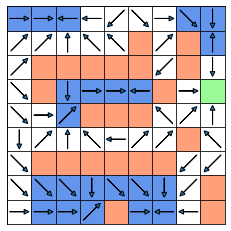

In [13]:
actions = np.arange(8) #we can move diagonally now, so we switch to 8 actions
V3, pi3 = valueIteration(rewards, statesRelevant, actions, False)
print("Optimal values with 8 actions:")
print(np.around(V3, 2))
drawPolicy(pi3)

## Task 3.4) 
Consider non-deterministic actions, where the agent moves with probability $0.8$ into the desired
direction, but with probability $0.1$ deviates $45°$ to the left and with probability $0.1$ deviates
$45°$ to the right of the desired direction. 

Compute again $V^*(s)$ and indicate $\pi^*(s)$ with arrows.

Discuss how value and policy changed, compared to $\textbf{3.3)}$!

Our framework is general enough to deal with the deviations from the get-go, so we just need to run the code from $\textbf{3.3)}$ with $\textit{deviations}$ set to $True$. For convenience, we draw the policy from the previous task again.

Optimal values with 8 actions and deviations:
[[52.92 52.88 52.92 52.89 48.39 60.72 68.96 74.37 69.97]
 [56.92 57.6  56.92 55.79 49.64  0.   72.15  0.   75.53]
 [48.02  0.    0.    0.    0.    0.   79.08  0.   94.07]
 [59.85  0.   68.2  69.14 65.58 67.12  0.   96.73  0.  ]
 [69.75 70.95 69.14  0.    0.    0.   83.11 96.97 94.07]
 [76.63 79.82 68.2  67.93 56.18 70.65 81.76  0.   82.84]
 [95.34  0.    0.    0.    0.    0.    0.   95.35 84.39]
 [98.76 99.97 99.97 99.97 96.68 99.98 99.98 98.77  0.  ]
 [98.77 99.97 99.98 99.98  0.   99.98 99.98 98.77  0.  ]]


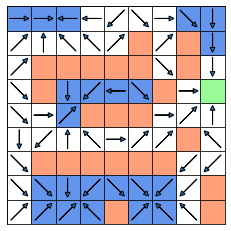

In [14]:
V4, pi4 = valueIteration(rewards, statesRelevant, actions, True)
print("Optimal values with 8 actions and deviations:")
print(np.around(V4, 2))
drawPolicy(pi4)

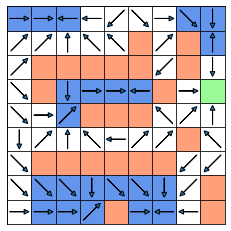

In [15]:
drawPolicy(pi3)

As we can see, the new policy is careful near the border of the grid, and tries to get away from it. This can be observed nicely at the bottom of the grid. Also, the agent is less willing to go for a permanent loop in the star cell in the center of the grid, the right-most star cell there actually tries to skip directly towards the goal. The same is true for the star cells in the top-right of the grid, in an uncertain environment close to the goal state, the agent now chooses to attempt to reach the goal.